# Import Data & Libraries

In [797]:
import glob
import numpy as np
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from scipy.stats import gaussian_kde
from mypulp import *
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
pd.set_option('display.max_columns' ,100)
pd.set_option('display.max_rows' ,100)
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.metrics import r2_score

In [275]:
df = pd.DataFrame()
for i in glob.glob("*csv"):
    df = pd.concat([df, pd.read_csv(i, encoding="cp932")])

del df["Unnamed: 0"]

del df["Unnamed: 0.1"]

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [276]:
df.columns.values

array(['日付', '開催', '天気', 'R', 'レース名', '映像', '頭数', '枠番', '馬番', 'オッズ', '人気',
       '着番', '騎手', '斤量', '距離', '馬場', '馬場指数', 'タイム', '着差', 'タイム指数', '通過',
       'ペース', '上り', '馬体重', '厩舎コメント', '備考', '勝ち馬(2着馬)', '賞金', '生年月日',
       '調教師', '馬主', '生産者', '産地', 'セリ取引価格', '獲得賞金', '通算成績', '主な勝鞍', '近親馬',
       '馬名'], dtype=object)

In [277]:
cols_ = ["Date", "Place", "Weather", "R", "Race_Name", "Movie", "Number_of_Heads", "Frame_Number", "Horse_Number", "Odds", "Popularity", 
"Arrival_Number", "Jockey", "Weight", "Distance_and_Type", "Course_Condition", "Course_Condition_Index", "Time", "Difference", "Time_Index","Passing", 
"Pace", "Final_Time","Horse_Weight", "Comment", "Others", "Winning_Horse(Second_Winner)", "Prize", "Birthday", 
"Trainer", "Owner", "Producer", "Origin", "Trading_Price", "Accumulate_Prize", "Accumulate_record", "Main_Win_Race", "Relative_Horse", 
"Horse_Name"]

In [278]:
rename_cols={}
for i in range(len(cols_)):
    rename_cols[df.columns.values[i]] = cols_[i]

In [279]:
df = df.rename(columns=rename_cols)

In [280]:
df.head(5)

,Date,Place,Weather,R,Race_Name,Movie,Number_of_Heads,Frame_Number,Horse_Number,Odds,Popularity,Arrival_Number,Jockey,Weight,Distance_and_Type,Course_Condition,Course_Condition_Index,Time,Difference,Time_Index,Passing,Pace,Final_Time,Horse_Weight,Comment,Others,Winning_Horse(Second_Winner),Prize,Birthday,Trainer,Owner,Producer,Origin,Trading_Price,Accumulate_Prize,Accumulate_record,Main_Win_Race,Relative_Horse,Horse_Name
0,2010/03/27,アラブ首,晴,,ドバイワールドC(G1),,14,,12,,,5,デットー,57.0,ダ2000,良,,,,,,,,計不,,,,,2006年2月25日,ビン・ス (海外),ゴドルフィン,Darley,英,-,0万円,1戦0勝 [0-0-0-1],NaN,Magic Tree,マスタリー Mastery
1,2010/11/07,アメリカ,NaN,,BCターフ(G1),,7,,7,,5,1,NaN,NaN,芝2400,良,,,,,,,,計不,,,(),,2006年,(海外),NaN,NaN,米,-,0万円,5戦3勝 [3-0-0-2],BCターフ,NaN,デンジャラスミッジ Dangerous Midge
2,2010/09/17,イギリス,NaN,,アークトライアル(G3),,,,9,,3,1,NaN,NaN,芝2200,NaN,,,,,,,,計不,,,(),,2006年,(海外),NaN,NaN,米,-,0万円,5戦3勝 [3-0-0-2],BCターフ,NaN,デンジャラスミッジ Dangerous Midge
3,2010/08/18,イギリス,NaN,,OP,,,,12,,5,8,NaN,NaN,芝2800,NaN,,,,,,,,計不,,,,,2006年,(海外),NaN,NaN,米,-,0万円,5戦3勝 [3-0-0-2],BCターフ,NaN,デンジャラスミッジ Dangerous Midge
4,2010/07/03,イギリス,NaN,,OP,,,,13,,5,1,NaN,NaN,芝2200,NaN,,,,,,,,計不,,,(),,2006年,(海外),NaN,NaN,米,-,0万円,5戦3勝 [3-0-0-2],BCターフ,NaN,デンジャラスミッジ Dangerous Midge


# Preprocessing Data

In [281]:
df["Date"] = pd.to_datetime(df["Date"])

In [282]:
df["Weather"] = df["Weather"].apply(lambda x: str(x).replace(" ", "").replace("小雨", "drizzle").replace("雨", "rain").replace("小雪", " light_snow").replace("晴", "sunny").replace("雪", "snow").replace("曇", "cloudy"))

In [283]:
df["R"] = df["R"].apply(lambda x :np.nan if x == " " else  int(x))
df["Number_of_Heads"] = df["Number_of_Heads"].apply(lambda x :np.nan if x == " " else  int(x))
df["Frame_Number"] = df["Frame_Number"].apply(lambda x :np.nan if x == " " else  int(x))
df["Horse_Number"] = df["Horse_Number"].apply(lambda x :np.nan if x == " " else  int(x))
df["Odds"] = df["Odds"].apply(lambda x :np.nan if x == " " else  float(str(x).replace(",", "")))
df["Popularity"] = df["Popularity"].apply(lambda x :np.nan if x == " " else  int(x))
df["Weight"] = df["Weight"].apply(lambda x:float(x))

In [284]:
df["Difference"] = df["Difference"].apply(lambda x :np.nan if x == " " else  float(x))

In [285]:
df["Distance_and_Type"] = df["Distance_and_Type"].fillna("無0")
distance_len = []
distance_type = []
for i in range(len(df)):
    if df["Distance_and_Type"].iat[i][0:1].isdigit() == False:
        if len(df["Distance_and_Type"].iat[i]) > 1:
            distance_type.append(df["Distance_and_Type"].iat[i][0:1])
            distance_len.append(int(df["Distance_and_Type"].iat[i][1:]))
        else:
            distance_type.append(df["Distance_and_Type"].iat[i][0:1])
            distance_len.append(0)
    else:
        distance_type.append("無")
        distance_len.append(int(df["Distance_and_Type"].iat[i][0:]))

In [286]:
df["Distance"] = distance_len

df["Type"] = distance_type

In [287]:
df["Type"] = df["Type"].apply(lambda x: x.replace("ダ", "DIRT").replace("芝", "TURF").replace("障", "OBSTACLE").replace("無", ""))

In [288]:
df["Time"] = df["Time"].apply(lambda x : float(x.split(":")[0])+float(x.split(":")[1])/60 if (":" in x) else np.nan)
df["Horse_Weight_Actual"] = df["Horse_Weight"].apply(lambda x : float(x.split("(")[0]) if "(" in x else np.nan)
df["Horse_Weight_Change"] = df["Horse_Weight"].apply(lambda x : float(x.split("(")[1].split(")")[0]) if "(" in x else np.nan)
df["Prize"] = df["Prize"].apply(lambda x : 0 if " " in x else float( x.replace(",", "")) )
df["Birthday"] = df["Birthday"].apply(lambda x : datetime.datetime(int( x.split("年")[0] ),
                                              int( x.split("年")[1].split("月")[0] ),
                                              int( x.split("年")[1].split("月")[1].split("日")[0] ),) if "月" in x else np.nan)

In [289]:
df["Weight_per_Horse_Weight"] = df["Weight"]/df["Horse_Weight_Actual"]

In [290]:
df["MPM"] = df["Distance"]/df["Time"]

In [291]:
df["MPM"] = df["MPM"].apply(lambda x : x if x != np.inf else np.nan)

In [292]:
df["Old"] = df.apply(lambda row: (row["Date"] - row["Birthday"]).total_seconds()/60/60/24/365.25, axis=1)

In [293]:
df["Course_Condition"] = df["Course_Condition"].apply(lambda x : str(x).replace("良", "Good_to_Firm/Standard").replace("稍", "Good").replace("重", "Yielding/Muddy").replace("不", "Soft/Sloppy"))

In [294]:
df["Foreign_or_Domestic"] = df["Trainer"].apply(lambda x : "Foreign" if "海外" in str(x) else "Domestic")

In [295]:
df.groupby("Foreign_or_Domestic")["MPM"].agg(["mean", "std", "count", "max", "min"])

,mean,std,count,max,min
Foreign_or_Domestic,,,,,
Domestic,943.431587,42.995659,198326,1113.172542,708.860759
Foreign,967.670501,70.366223,1646,1107.011070,0.000000


# Descriptive Analysis

In [296]:
df.dtypes

Date                            datetime64[ns]
Place                                   object
Weather                                 object
R                                      float64
Race_Name                               object
Movie                                   object
Number_of_Heads                        float64
Frame_Number                           float64
Horse_Number                             int64
Odds                                   float64
Popularity                             float64
Arrival_Number                          object
Jockey                                  object
Weight                                 float64
Distance_and_Type                       object
Course_Condition                        object
Course_Condition_Index                  object
Time                                   float64
Difference                             float64
Time_Index                              object
Passing                                 object
Pace         

## Type

In [297]:
df["Type"].value_counts()

DIRT        154483
TURF         46129
OBSTACLE      2007
                13
Name: Type, dtype: int64

In [298]:
df1 = df[(df["Type"] == "DIRT") | (df["Type"] == "TURF")].reset_index(drop=True)

## MPM

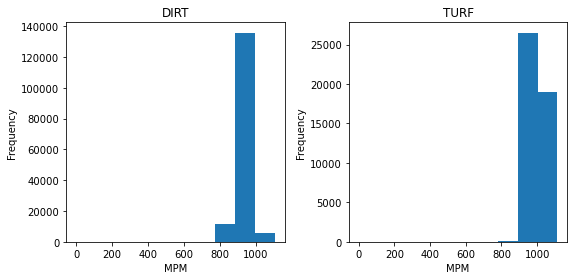

In [299]:
plt.figure(figsize=(12, 4), tight_layout=True)
k = 1
for type_ in df1["Type"].unique():
    if type_ != "":
        plt.subplot(1, 3, k)
        plt.title(type_)
        plt.hist(df1[df1["Type"] == type_]["MPM"])
        plt.xlabel("MPM")
        plt.ylabel("Frequency")

        k += 1
plt.show()

In [300]:
for type_ in df1["Type"].unique():
    print(type_)
    print(np.percentile(df1[df1["Type"] == type_].dropna()["MPM"], 1))

DIRT
862.8318584070797
TURF
918.9534141671984


In [301]:
use_ = []
dirt_min =  np.percentile(df1[df1["Type"] == "DIRT"].dropna()["MPM"], 1)
turf_min =  np.percentile(df1[df1["Type"] == "TURF"].dropna()["MPM"], 1)
for i in range(len(df1)):
    if df1["Type"].iat[i] == "DIRT" and df1["MPM"].iat[i] >=dirt_min:
        use_.append(True)
    elif df1["Type"].iat[i] == "TURF" and df1["MPM"].iat[i] >= turf_min:
        use_.append(True)
    else:
        use_.append(False)

In [302]:
df2 = df1[np.array(use_)].reset_index(drop=True)

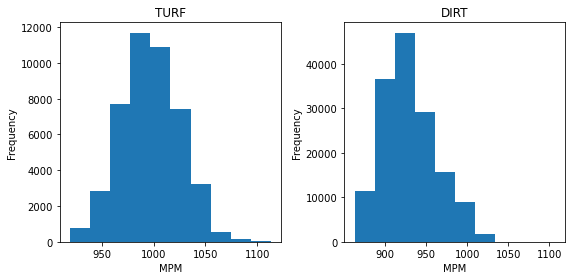

In [303]:
plt.figure(figsize=(12, 4), tight_layout=True)
k = 1
for type_ in df2["Type"].unique():
    if type_ != "":
        plt.subplot(1, 3, k)
        plt.title(type_)
        plt.hist(df2[df2["Type"] == type_]["MPM"])
        plt.xlabel("MPM")
        plt.ylabel("Frequency")

        k += 1
plt.show()

## Origin

In [304]:
len(df2["Origin"].unique())

294

In [305]:
origin = df2.groupby("Origin")["MPM"].agg(["mean", "std", "count"]).sort_values("mean", ascending=False)[0:100]

<Figure size 432x288 with 0 Axes>

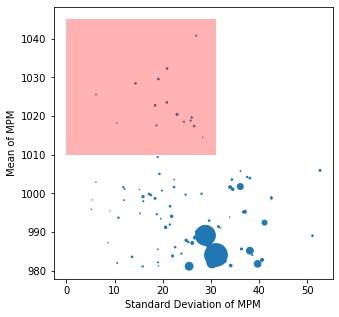

<Figure size 432x288 with 0 Axes>

In [306]:
plt.figure(figsize=(5, 5))
plt.scatter( origin["std"], origin["mean"], s=origin["count"]*0.1)
plt.xlabel("Standard Deviation of MPM")
plt.ylabel("Mean of MPM")
plt.fill_between([0, 31],1045,1010,facecolor="red",alpha=0.3)
plt.figure()

In [307]:
origin[(origin["mean"] >= 1010) & (origin["std"] <= 31)]

,mean,std,count
Origin,,,
Sally J. Andersen,1040.777051,26.972590,9
土田農場,1032.281655,20.905000,24
村下清志,1029.556107,19.121881,25
Bryan Connors,1028.441617,14.357008,24
ストームファームコーポレーション,1025.545513,6.162451,5
Dr. Christoph Berglar,1023.512496,20.864782,26
三村卓也,1022.765928,18.431825,27
様似堀牧場,1020.410355,22.991994,42
ヤマイチ牧場,1019.632356,26.037037,19


## Jockey

In [308]:
len(df2["Jockey"].unique())

1494

In [309]:
jockey = df2.groupby("Jockey")["MPM"].agg(["mean", "std", "count"]).sort_values("mean", ascending=False)[0:100]

<Figure size 432x288 with 0 Axes>

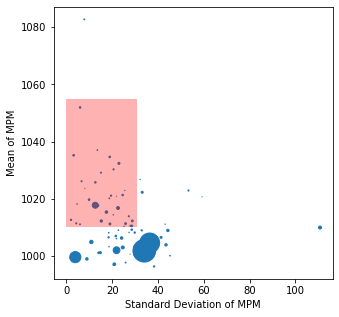

<Figure size 432x288 with 0 Axes>

In [310]:
plt.figure(figsize=(5, 5))
plt.scatter( jockey["std"], jockey["mean"], s=origin["count"]*0.1)
plt.xlabel("Standard Deviation of MPM")
plt.ylabel("Mean of MPM")
plt.fill_between([0, 31],1055,1010,facecolor="red",alpha=0.3)
plt.figure()

In [311]:
jockey[(jockey["mean"] >= 1010) & (jockey["std"] <= 31)]

,mean,std,count
Jockey,,,
ダーテン,1082.735070,7.828787,2
アングラ,1051.936504,5.981902,3
ペイン,1037.041647,13.509923,4
ラマス,1035.231271,3.157523,2
穂苅寿彦,1034.655765,18.921003,2
上野翔,1032.413588,22.936189,6
アーノル,1030.301210,20.593411,6
マッケイ,1029.174373,15.113670,2
デルペッ,1026.156827,6.625878,3


## Trainer

In [312]:
len(df2["Trainer"].unique())

1188

In [313]:
trainer = df2.groupby("Trainer")["MPM"].agg(["mean", "std", "count"]).sort_values("mean", ascending=False)[0:100]

<Figure size 432x288 with 0 Axes>

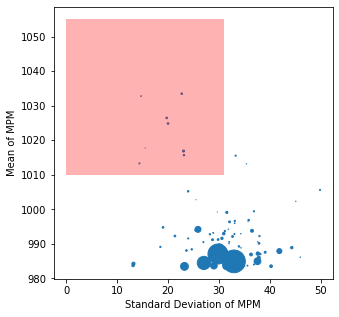

<Figure size 432x288 with 0 Axes>

In [314]:
plt.figure(figsize=(5, 5))
plt.scatter( trainer["std"], trainer["mean"], s=origin["count"]*0.1)
plt.xlabel("Standard Deviation of MPM")
plt.ylabel("Mean of MPM")
plt.fill_between([0, 31],1055,1010,facecolor="red",alpha=0.3)
plt.figure()

In [315]:
trainer[(trainer["mean"] >= 1010) & (trainer["std"] <= 31)]

,mean,std,count
Trainer,,,
イウ (海外),1033.481440,22.684581,25
オサリバ (海外),1032.783646,14.701652,35
モートン (海外),1026.470288,19.728471,11
バリッジ (海外),1024.836511,19.990983,6
サイズ (海外),1017.809348,15.514544,96
ファウン (海外),1016.875872,23.041870,152
シュッツ (海外),1015.687089,23.126910,16
スマガ (海外),1013.294477,14.367958,2


## Horse_Weight_Actual

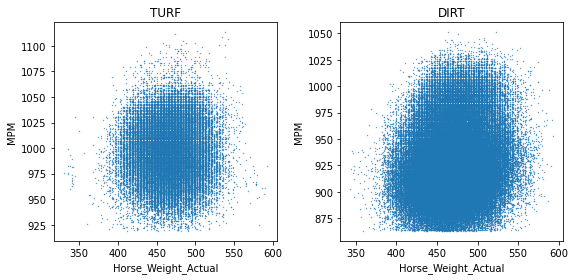

In [316]:
plt.figure(figsize=(12, 4), tight_layout=True)
k = 1
for type_ in df2["Type"].unique():
    if type_ != "":
        plt.subplot(1, 3, k)
        plt.title(type_)
        plt.scatter(df2[df2["Type"] == type_]["Horse_Weight_Actual"], df2[df2["Type"] == type_]["MPM"], s=.1)
        plt.xlabel("Horse_Weight_Actual")
        plt.ylabel("MPM")

        k += 1
plt.show()

## Horse_Weight_Change

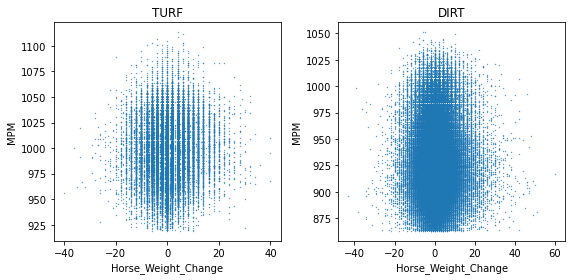

In [317]:
plt.figure(figsize=(12, 4), tight_layout=True)
k = 1
for type_ in df2["Type"].unique():
    if type_ != "":
        plt.subplot(1, 3, k)
        plt.title(type_)
        plt.scatter(df2[df2["Type"] == type_]["Horse_Weight_Change"], df2[df2["Type"] == type_]["MPM"], s=.1)
        plt.xlabel("Horse_Weight_Change")
        plt.ylabel("MPM")

        k += 1
plt.show()

## Weight_per_Horse_Weight

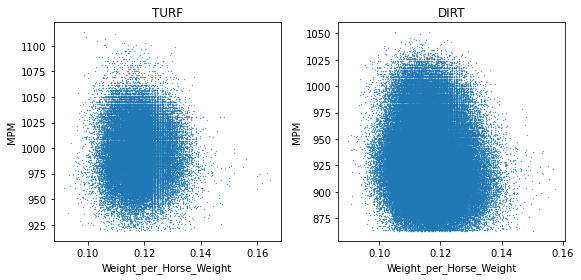

In [370]:
plt.figure(figsize=(12, 4), tight_layout=True)
k = 1
for type_ in df2["Type"].unique():
    if type_ != "":
        plt.subplot(1, 3, k)
        plt.title(type_)
        plt.scatter(df2[df2["Type"] == type_]["Weight_per_Horse_Weight"], df2[df2["Type"] == type_]["MPM"], s=.1)
        plt.xlabel("Weight_per_Horse_Weight")
        plt.ylabel("MPM")

        k += 1
plt.show()

## Old

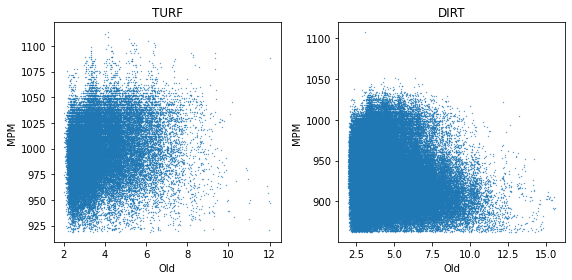

In [318]:
plt.figure(figsize=(12, 4), tight_layout=True)
k = 1
for type_ in df2["Type"].unique():
    if type_ != "":
        plt.subplot(1, 3, k)
        plt.title(type_)
        plt.scatter(df2[df2["Type"] == type_]["Old"], df2[df2["Type"] == type_]["MPM"], s=.1)
        plt.xlabel("Old")
        plt.ylabel("MPM")

        k += 1
plt.show()

## Frame_Number

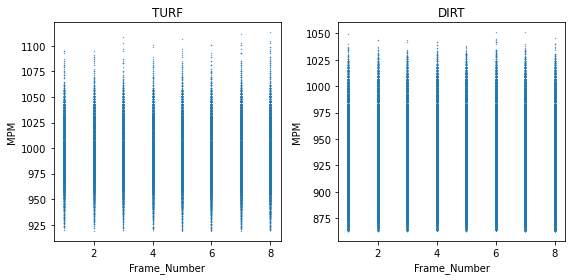

In [319]:
plt.figure(figsize=(12, 4), tight_layout=True)
k = 1
for type_ in df2["Type"].unique():
    if type_ != "":
        plt.subplot(1, 3, k)
        plt.title(type_)
        plt.scatter(df2[df2["Type"] == type_]["Frame_Number"], df2[df2["Type"] == type_]["MPM"], s=.1)
        plt.xlabel("Frame_Number")
        plt.ylabel("MPM")

        k += 1
plt.show()

## Number_of_Heads

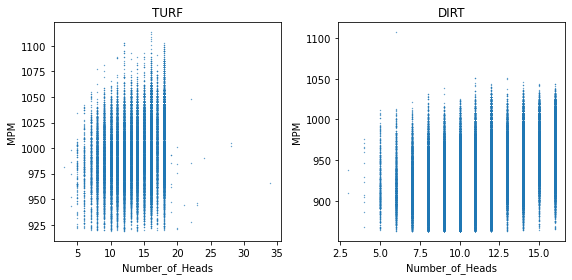

In [320]:
plt.figure(figsize=(12, 4), tight_layout=True)
k = 1
for type_ in df2["Type"].unique():
    if type_ != "":
        plt.subplot(1, 3, k)
        plt.title(type_)
        plt.scatter(df2[df2["Type"] == type_]["Number_of_Heads"], df2[df2["Type"] == type_]["MPM"], s=.1)
        plt.xlabel("Number_of_Heads")
        plt.ylabel("MPM")

        k += 1
plt.show()

In [321]:
df2["Number_of_Heads"].value_counts()

10.0    34016
16.0    28698
12.0    27108
9.0     21099
11.0    20290
14.0    15257
8.0     12534
15.0    10613
13.0    10600
18.0     6658
7.0      4938
17.0     1845
6.0      1631
5.0       562
4.0        18
19.0        7
20.0        5
22.0        3
3.0         3
23.0        2
28.0        2
24.0        1
34.0        1
21.0        1
Name: Number_of_Heads, dtype: int64

In [322]:
df3 = df2[(df2["Number_of_Heads"] >= 8) & (df2["Number_of_Heads"] <= 16)].reset_index(drop=True)

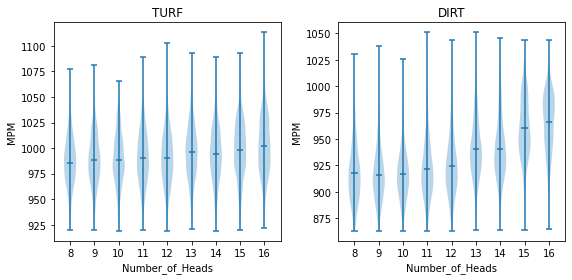

In [323]:
plt.figure(figsize=(12, 4), tight_layout=True)
k = 1
for type_ in df3["Type"].unique():
    if type_ != "":
        plt.subplot(1, 3, k)
        plt.title(type_)
        plt.violinplot([df3["MPM"][(df3["Number_of_Heads"] == i) & (df3["Type"] == type_)] for i in range(8, 17, 1)], showmeans=True)
        plt.xticks(ticks=np.arange(1, 10, 1), labels=["{}".format(i) for i in np.arange(8, 17, 1)])
        plt.xlabel("Number_of_Heads")
        plt.ylabel("MPM")

        k += 1
plt.show()

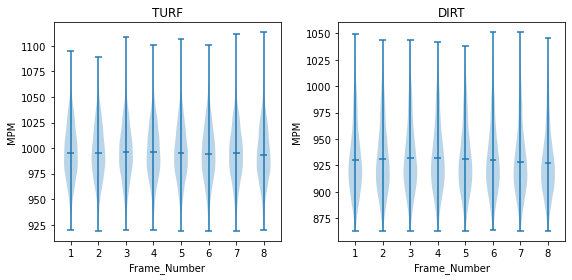

In [324]:
plt.figure(figsize=(12, 4), tight_layout=True)
k = 1
for type_ in df3["Type"].unique():
    if type_ != "":
        plt.subplot(1, 3, k)
        plt.title(type_)
        plt.violinplot([df3["MPM"][(df3["Frame_Number"] == i) & (df3["Type"] == type_)] for i in range(1, 9, 1)], showmeans=True)
        plt.xticks(ticks=np.arange(1, 9, 1), labels=["{}".format(i) for i in np.arange(1, 9, 1)])
        plt.xlabel("Frame_Number")
        plt.ylabel("MPM")

        k += 1
plt.show()

## Weather

In [325]:
weather_list = ['sunny', 'cloudy','drizzle','rain',  ' light_snow','snow' ]

In [326]:
weather_list

['sunny', 'cloudy', 'drizzle', 'rain', ' light_snow', 'snow']

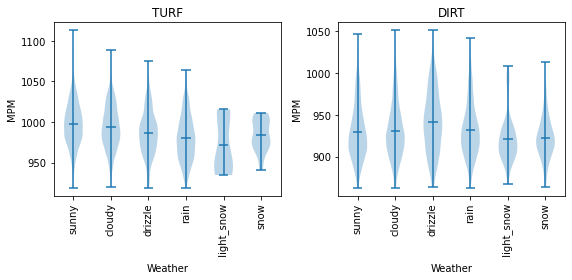

In [338]:
plt.figure(figsize=(12, 4), tight_layout=True)
k = 1
for type_ in df3["Type"].unique():
    if type_ != "":
        plt.subplot(1, 3, k)
        plt.title(type_)
        plt.violinplot([df3["MPM"][(df3["Weather"] == i) & (df3["Type"] == type_)] for i in weather_list], showmeans=True)
        plt.xticks(ticks=np.arange(1, 7, 1), labels=weather_list, rotation=90)
        plt.xlabel("Weather")
        plt.ylabel("MPM")

        k += 1
plt.show()

## Course_Condition

In [331]:
df["Course_Condition"].unique()

array(['Good_to_Firm/Standard', 'nan', 'Yielding/Muddy', 'Good',
       'Soft/Sloppy'], dtype=object)

In [333]:
condition = ['Good_to_Firm/Standard',  'Good', 'Yielding/Muddy',
       'Soft/Sloppy']

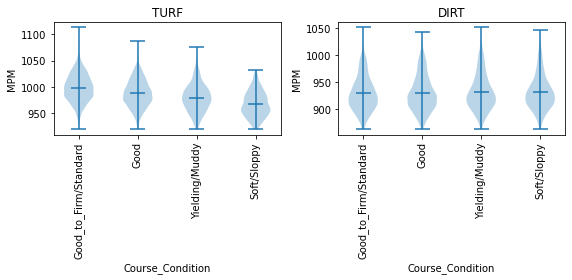

In [339]:
plt.figure(figsize=(12, 4), tight_layout=True)
k = 1
for type_ in df3["Type"].unique():
    if type_ != "":
        plt.subplot(1, 3, k)
        plt.title(type_)
        plt.violinplot([df3["MPM"][(df3["Course_Condition"] == i) & (df3["Type"] == type_)] for i in condition], showmeans=True)
        plt.xticks(ticks=np.arange(1, 5, 1), labels=condition, rotation=90)
        plt.xlabel("Course_Condition")
        plt.ylabel("MPM")

        k += 1
plt.show()

## Distance

In [345]:
distance = df["Distance"].unique()
distance.sort()

In [346]:
distance

array([   0,  750,  760,  800,  820,  850,  900,  950, 1000, 1010, 1100,
       1130, 1150, 1175, 1180, 1190, 1200, 1220, 1230, 1250, 1300, 1320,
       1330, 1350, 1390, 1400, 1420, 1430, 1445, 1450, 1490, 1500, 1550,
       1590, 1600, 1612, 1613, 1620, 1650, 1660, 1670, 1690, 1700, 1725,
       1730, 1750, 1760, 1777, 1790, 1794, 1800, 1850, 1856, 1870, 1900,
       1980, 1990, 2000, 2010, 2018, 2020, 2040, 2050, 2060, 2080, 2088,
       2100, 2150, 2175, 2180, 2200, 2250, 2280, 2300, 2350, 2380, 2388,
       2390, 2400, 2410, 2425, 2450, 2460, 2480, 2485, 2500, 2550, 2600,
       2650, 2660, 2680, 2700, 2750, 2770, 2800, 2850, 2860, 2880, 2890,
       2900, 2910, 2920, 2950, 2970, 3000, 3100, 3110, 3140, 3170, 3200,
       3210, 3242, 3250, 3284, 3290, 3300, 3330, 3350, 3370, 3380, 3390,
       3400, 3430, 3450, 3500, 3520, 3570, 3600, 3700, 3712, 3717, 3721,
       3800, 3900, 3930, 4000, 4050, 4100, 4150, 4200, 4250, 4300, 4350,
       4400, 4500, 4530, 4600, 4800, 4900, 5000, 56

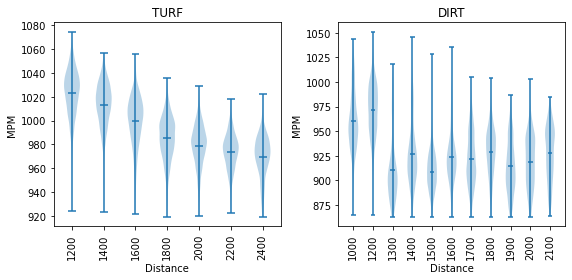

In [369]:
plt.figure(figsize=(12, 4), tight_layout=True)
k = 1
for type_ in df3["Type"].unique():
    if type_ != "":
        plt.subplot(1, 3, k)
        plt.title(type_)
        threshold = 1000
        temp1 = [i for i in distance[1:] if len(df3["MPM"][(df3["Distance"] == i) & (df3["Type"] == type_)]) >= threshold]
        temp2 = [df3["MPM"][(df3["Distance"] == i) & (df3["Type"] == type_)] for i in distance[1:] if len(df3["MPM"][(df3["Distance"] == i) & (df3["Type"] == type_)]) >= threshold]
        plt.violinplot(temp2, showmeans=True)
        plt.xticks(ticks=np.arange(1, len(temp1)+1, 1), labels=temp1, rotation=90)
        plt.xlabel("Distance")
        plt.ylabel("MPM")

        k += 1
plt.show()

# Create Machine Learning Model

## Preprocessing Data(divide data into train, test and valid)

In [392]:
df3 = df3.sort_values(["Horse_Name", "Date"]).reset_index(drop=True)

In [393]:
select1 = df3["Course_Condition"] != "nan"

In [394]:
select2 =  (df3["Weather"] != "") | (df3["Weather"] != "nan")

In [395]:
df3.columns.values

array(['Date', 'Place', 'Weather', 'R', 'Race_Name', 'Movie',
       'Number_of_Heads', 'Frame_Number', 'Horse_Number', 'Odds',
       'Popularity', 'Arrival_Number', 'Jockey', 'Weight',
       'Distance_and_Type', 'Course_Condition', 'Course_Condition_Index',
       'Time', 'Difference', 'Time_Index', 'Passing', 'Pace',
       'Final_Time', 'Horse_Weight', 'Comment', 'Others',
       'Winning_Horse(Second_Winner)', 'Prize', 'Birthday', 'Trainer',
       'Owner', 'Producer', 'Origin', 'Trading_Price', 'Accumulate_Prize',
       'Accumulate_record', 'Main_Win_Race', 'Relative_Horse',
       'Horse_Name', 'Distance', 'Type', 'Horse_Weight_Actual',
       'Horse_Weight_Change', 'Weight_per_Horse_Weight', 'MPM', 'Old',
       'Foreign_or_Domestic'], dtype=object)

In [396]:
df3["Interval"] = df3["Date"].diff().apply(lambda x : x.days)

In [398]:
for_rename = [ ["{}_{}".format(df3.columns.values[j],i) for j in range(len(df3.columns.values))] for i in range(1, 4, 1)]

In [408]:
dict1 = {}
dict2 = {}
dict3 = {}
for i in range(len( for_rename[0] )) :
    dict1[df3.columns.values[i]] = for_rename[0][i]
for i in range(len( for_rename[1] )) :
    dict2[df3.columns.values[i]] = for_rename[1][i]
for i in range(len( for_rename[2] )) :
    dict3[df3.columns.values[i]] = for_rename[2][i]

In [424]:
df4 = df3.copy()

In [425]:
df4 = pd.merge(df4,  df3.shift(periods=1).rename(columns=dict1),  left_index=True, right_index=True)

In [426]:
df4 = pd.merge(df4,  df3.shift(periods=2).rename(columns=dict2),  left_index=True, right_index=True)

In [427]:
df4 = pd.merge(df4,  df3.shift(periods=3).rename(columns=dict3),  left_index=True, right_index=True)

In [434]:
select3 = (df4["Horse_Name"] == df4["Horse_Name_1"]) & (df4["Horse_Name_1"] == df4["Horse_Name_2"]) & (df4["Horse_Name_2"] == df4["Horse_Name_3"])

In [454]:
df5 = df4[select1 & select2 & select3].reset_index(drop=True)

In [465]:
df5.columns.values[:int(len(df5.columns.values)/4)]

array(['Date', 'Place', 'Weather', 'R', 'Race_Name', 'Movie',
       'Number_of_Heads', 'Frame_Number', 'Horse_Number', 'Odds',
       'Popularity', 'Arrival_Number', 'Jockey', 'Weight',
       'Distance_and_Type', 'Course_Condition', 'Course_Condition_Index',
       'Time', 'Difference', 'Time_Index', 'Passing', 'Pace',
       'Final_Time', 'Horse_Weight', 'Comment', 'Others',
       'Winning_Horse(Second_Winner)', 'Prize', 'Birthday', 'Trainer',
       'Owner', 'Producer', 'Origin', 'Trading_Price', 'Accumulate_Prize',
       'Accumulate_record', 'Main_Win_Race', 'Relative_Horse',
       'Horse_Name', 'Distance', 'Type', 'Horse_Weight_Actual',
       'Horse_Weight_Change', 'Weight_per_Horse_Weight', 'MPM', 'Old',
       'Foreign_or_Domestic', 'Interval'], dtype=object)

In [564]:
cols = ["MPM","Weather", "Number_of_Heads", "Frame_Number", "Horse_Number", "Course_Condition", "Distance", "Horse_Weight_Actual", 
        "Horse_Weight_Change", "Weight_per_Horse_Weight",  "Old", "Interval"]

In [565]:
analyze_cols = cols + ["{}_{}".format(j, i) for j in cols for i in range(1, 4,1)]

In [566]:
df6 = df5[df5[analyze_cols].isnull().sum(axis=1) == 0]

In [567]:
df_DIRT = df6[df6["Type"] == "DIRT"].reset_index(drop=True)
df_TURF = df6[df6["Type"] == "TURF"].reset_index(drop=True)

In [568]:
Num_heads_dirt = df_DIRT.groupby(['Date', 'Place',  'R', 'Race_Name'])["Number_of_Heads"].mean()

R_count_dirt = df_DIRT.groupby(['Date', 'Place',  'R', 'Race_Name'])["R"].count()

valid_race_dirt = Num_heads_dirt[Num_heads_dirt == R_count_dirt]

Num_heads_turf = df_TURF.groupby(['Date', 'Place',  'R', 'Race_Name'])["Number_of_Heads"].mean()

R_count_turf = df_TURF.groupby(['Date', 'Place',  'R', 'Race_Name'])["R"].count()

valid_race_turf = Num_heads_turf[Num_heads_turf == R_count_turf]

In [569]:
valid_race_dirt1 = valid_race_dirt.reset_index().rename(columns={"Number_of_Heads":"Valid"})
valid_race_turf1 = valid_race_turf.reset_index().rename(columns={"Number_of_Heads":"Valid"})

In [570]:
df_DIRT_add_Valid = pd.merge(df_DIRT, valid_race_dirt1, on = ['Date', 'Place',  'R', 'Race_Name'], how="left" )
df_TURF_add_Valid = pd.merge(df_TURF, valid_race_turf1, on = ['Date', 'Place',  'R', 'Race_Name'], how="left" )

In [571]:
df_DIRT_analyze = df_DIRT_add_Valid[analyze_cols+["Valid"]]
df_TURF_analyze = df_TURF_add_Valid[analyze_cols+["Valid"]]

In [572]:
df_DIRT_analyze_dummies = pd.get_dummies(df_DIRT_analyze,drop_first=True )
df_TURF_analyze_dummies = pd.get_dummies(df_TURF_analyze,drop_first=True )

In [783]:
df_DIRT_analyze_dummies_traintest = df_DIRT_analyze_dummies[df_DIRT_analyze_dummies["Valid"].isnull()]
df_TURF_analyze_dummies_traintest = df_TURF_analyze_dummies[df_TURF_analyze_dummies["Valid"].isnull()]
df_DIRT_analyze_dummies_valid = df_DIRT_analyze_dummies[~df_DIRT_analyze_dummies["Valid"].isnull()]
df_TURF_analyze_dummies_valid = df_TURF_analyze_dummies[~df_TURF_analyze_dummies["Valid"].isnull()]

del df_DIRT_analyze_dummies_traintest["Valid"]
del df_TURF_analyze_dummies_traintest["Valid"]
del df_DIRT_analyze_dummies_valid["Valid"]
del df_TURF_analyze_dummies_valid["Valid"]

In [768]:
X_train_dirt, X_test_dirt, y_train_dirt, y_test_dirt = train_test_split(df_DIRT_analyze_dummies_traintest.drop("MPM", axis=1), df_DIRT_analyze_dummies_traintest[["MPM"]])
X_train_turf, X_test_turf, y_train_turf, y_test_turf = train_test_split(df_TURF_analyze_dummies_traintest.drop("MPM", axis=1), df_TURF_analyze_dummies_traintest[["MPM"]])
X_valid_dirt, y_valid_dirt = df_DIRT_analyze_dummies_valid.drop("MPM", axis=1), df_DIRT_analyze_dummies_valid[["MPM"]]
X_valid_turf, y_valid_turf = df_TURF_analyze_dummies_valid.drop("MPM", axis=1), df_TURF_analyze_dummies_valid[["MPM"]]

In [769]:
sc_dirt_X = StandardScaler()
sc_dirt_y = StandardScaler()
sc_turf_X = StandardScaler()
sc_turf_y = StandardScaler()

In [770]:
X_train_dirt_std = sc_dirt_X.fit_transform(X_train_dirt)
X_test_dirt_std = sc_dirt_X.transform(X_test_dirt)
X_valid_dirt_std = sc_dirt_X.transform(X_valid_dirt)

y_train_dirt_std = sc_dirt_y.fit_transform(y_train_dirt)
y_test_dirt_std = sc_dirt_y.transform(y_test_dirt)
y_valid_dirt_std = sc_dirt_y.transform(y_valid_dirt)

X_train_turf_std = sc_turf_X.fit_transform(X_train_turf)
X_test_turf_std = sc_turf_X.transform(X_test_turf)
X_valid_turf_std = sc_turf_X.transform(X_valid_turf)

y_train_turf_std = sc_turf_y.fit_transform(y_train_turf)
y_test_turf_std = sc_turf_y.transform(y_test_turf)
y_valid_turf_std = sc_turf_y.transform(y_valid_turf)

## Use Lasso

In [771]:
GS_dirt=GridSearchCV(Lasso(), {"alpha":[0.001, 0.01, 0.1, 1]},cv=5 )
GS_turf=GridSearchCV(Lasso(), {"alpha":[0.001, 0.01, 0.1, 1]},cv=5 )

In [772]:
GS_dirt.fit(X_train_dirt_std, y_train_dirt_std)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1]})

In [773]:
GS_dirt.best_params_

{'alpha': 0.001}

In [774]:
GS_turf.fit(X_train_turf_std, y_train_turf_std)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1]})

In [775]:
GS_turf.best_params_

{'alpha': 0.001}

In [903]:
lasso_dirt = Lasso(alpha=0.006739)
lasso_dirt.fit(X_train_dirt_std, y_train_dirt_std)
print(lasso_dirt.score(X_train_dirt_std, y_train_dirt_std))
print(lasso_dirt.score(X_test_dirt_std, y_test_dirt_std))
print(lasso_dirt.score(X_valid_dirt_std, y_valid_dirt_std))

0.7308911105786966
0.7280010945870595
0.6227873820237491


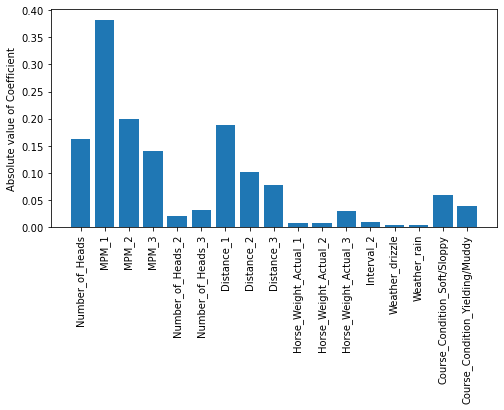

In [991]:
plt.figure(figsize=(8, 4))
plt.bar( df_DIRT_analyze_dummies_traintest.columns.values[1:][lasso_dirt.coef_>0], lasso_dirt.coef_[lasso_dirt.coef_>0] )
plt.xticks(rotation=90)
plt.ylabel("Absolute value of Coefficient")
plt.show()

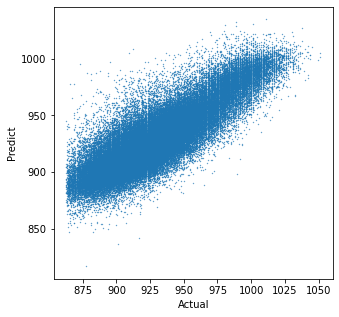

In [992]:
plt.figure(figsize=(5, 5))
plt.scatter( sc_dirt_y.inverse_transform(y_train_dirt_std) , sc_dirt_y.inverse_transform(lasso_dirt.predict(X_train_dirt_std)), s=.1)
plt.xlabel("Actual")
plt.ylabel("Predict")
plt.show()

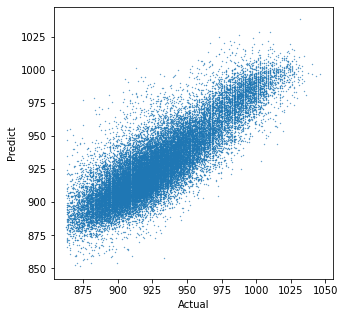

In [994]:
plt.figure(figsize=(5, 5))
plt.scatter( sc_dirt_y.inverse_transform(y_test_dirt_std) , sc_dirt_y.inverse_transform(lasso_dirt.predict(X_test_dirt_std)), s=.1)
plt.xlabel("Actual")
plt.ylabel("Predict")
plt.show()

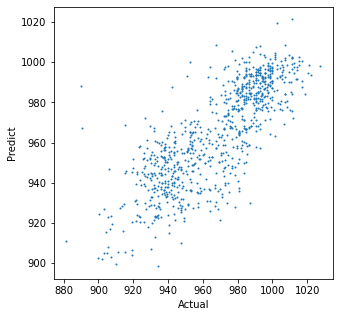

In [995]:
plt.figure(figsize=(5, 5))
plt.scatter( sc_dirt_y.inverse_transform(y_valid_dirt_std) , sc_dirt_y.inverse_transform(lasso_dirt.predict(X_valid_dirt_std)), s=1)
plt.xlabel("Actual")
plt.ylabel("Predict")
plt.show()

In [908]:
lasso_turf = Lasso(alpha=0.006739)
lasso_turf.fit(X_train_turf_std, y_train_turf_std)
print(lasso_turf.score(X_train_turf_std, y_train_turf_std))
print(lasso_turf.score(X_test_turf_std, y_test_turf_std))
print(lasso_turf.score(X_valid_turf_std, y_valid_turf_std))

0.7216775784747593
0.715303869017325
0.754620683618299


In [909]:
df_TURF_analyze_dummies_traintest

,MPM,Number_of_Heads,Frame_Number,Horse_Number,Distance,Horse_Weight_Actual,Horse_Weight_Change,Weight_per_Horse_Weight,Old,Interval,MPM_1,MPM_2,MPM_3,Number_of_Heads_1,Number_of_Heads_2,Number_of_Heads_3,Frame_Number_1,Frame_Number_2,Frame_Number_3,Horse_Number_1,Horse_Number_2,Horse_Number_3,Distance_1,Distance_2,Distance_3,Horse_Weight_Actual_1,Horse_Weight_Actual_2,Horse_Weight_Actual_3,Horse_Weight_Change_1,Horse_Weight_Change_2,Horse_Weight_Change_3,Weight_per_Horse_Weight_1,Weight_per_Horse_Weight_2,Weight_per_Horse_Weight_3,Old_1,Old_2,Old_3,Interval_1,Interval_2,Interval_3,Weather_cloudy,Weather_drizzle,Weather_rain,Weather_snow,Weather_sunny,Course_Condition_Good_to_Firm/Standard,Course_Condition_Soft/Sloppy,Course_Condition_Yielding/Muddy,Weather_1_cloudy,Weather_1_drizzle,Weather_1_rain,Weather_1_snow,Weather_1_sunny,Weather_2_cloudy,Weather_2_drizzle,Weather_2_rain,Weather_2_snow,Weather_2_sunny,Weather_3_cloudy,Weather_3_drizzle,Weather_3_rain,Weather_3_snow,Weather_3_sunny,Course_Condition_1_Good_to_Firm/Standard,Course_Condition_1_Soft/Sloppy,Course_Condition_1_Yielding/Muddy,Course_Condition_2_Good_to_Firm/Standard,Course_Condition_2_Soft/Sloppy,Course_Condition_2_Yielding/Muddy,Course_Condition_3_Good_to_Firm/Standard,Course_Condition_3_Soft/Sloppy,Course_Condition_3_Yielding/Muddy
0,1005.586592,16.0,1.0,2,1200,418.0,-2.0,0.126794,2.425736,31.0,946.372240,956.937799,961.538462,9.0,8.0,11.0,4.0,7.0,2.0,4.0,7.0,2.0,1000.0,1000.0,1000.0,420.0,412.0,416.0,8.0,-4.0,0.0,0.126190,0.128641,0.127404,2.340862,2.247775,2.225873,34.0,8.0,36.0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0
1,995.850622,14.0,8.0,13,1200,410.0,-8.0,0.129268,2.464066,14.0,1005.586592,946.372240,956.937799,16.0,9.0,8.0,1.0,4.0,7.0,2.0,4.0,7.0,1200.0,1000.0,1000.0,418.0,420.0,412.0,-2.0,8.0,-4.0,0.126794,0.126190,0.128641,2.425736,2.340862,2.247775,31.0,34.0,8.0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1
2,967.741935,15.0,6.0,10,1800,458.0,-10.0,0.117904,2.576318,40.0,888.888889,896.265560,912.547529,13.0,10.0,8.0,4.0,8.0,3.0,5.0,10.0,3.0,1800.0,1800.0,1600.0,468.0,466.0,464.0,2.0,2.0,2.0,0.119658,0.115880,0.116379,2.466804,2.431211,2.354552,13.0,28.0,14.0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0
3,931.837791,14.0,8.0,13,1800,462.0,0.0,0.116883,3.088296,56.0,911.854103,886.699507,878.906250,12.0,10.0,9.0,3.0,8.0,4.0,3.0,9.0,4.0,1500.0,1500.0,1500.0,463.0,464.0,461.0,-1.0,3.0,-13.0,0.116631,0.118534,0.119306,2.934976,2.874743,2.822724,22.0,19.0,34.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0
4,1015.514810,15.0,6.0,11,1200,416.0,-6.0,0.127404,2.433949,17.0,944.881890,871.248790,978.792822,11.0,8.0,8.0,4.0,1.0,4.0,4.0,1.0,4.0,1000.0,1500.0,1000.0,422.0,422.0,398.0,0.0,-6.0,0.0,0.127962,0.125592,0.133166,2.387406,2.365503,2.042437,8.0,118.0,-1091.0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23621,993.975904,11.0,4.0,4,2200,520.0,22.0,0.103846,3.290897,92.0,976.491863,980.392157,964.501005,10.0,9.0,14.0,1.0,4.0,3.0,1.0,4.0,3.0,1800.0,2000.0,2400.0,498.0,506.0,516.0,-8.0,-10.0,18.0,0.112450,0.110672,0.108527,3.039014,2.850103,2.754278,69.0,35.0,105.0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
23622,1000.000000,13.0,6.0,9,1600,436.0,0.0,0.116972,2.606434,14.0,1006.289308,1002.785515,919.148936,9.0,11.0,16.0,1.0,8.0,1.0,1.0,11.0,1.0,1600.0,1800.0,1800.0,436.0,444.0,446.0,-8.0,-2.0,0.0,0.116972,0.114865,0.114350,2.568104,2.527036,2.469541,15.0,21.0,-1533.0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
23623,984.615385,16.0,2.0,3,1600,440.0,4.0,0.122727,2.852841,90.0,1000.000000,1006.289308,1002.785515,13.0,9.0,11.0,6.0,1.0,8.0

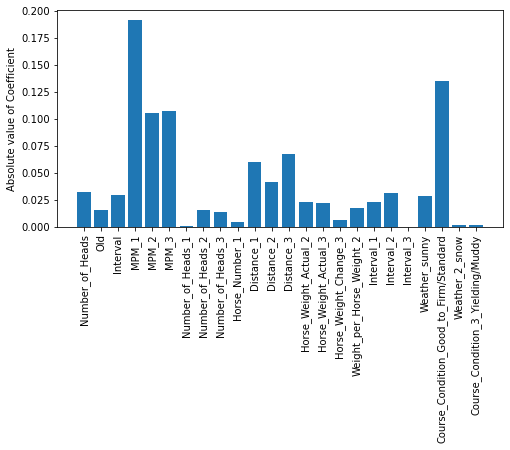

In [990]:
plt.figure(figsize=(8, 4))
plt.bar( df_TURF_analyze_dummies_traintest.columns.values[1:][lasso_turf.coef_>0], lasso_turf.coef_[lasso_turf.coef_>0] )
plt.xticks(rotation=90)
plt.ylabel("Absolute value of Coefficient")
plt.show()

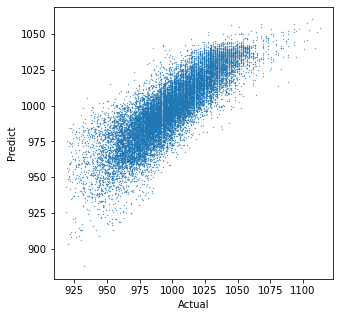

In [987]:
plt.figure(figsize=(5, 5))
plt.scatter( sc_turf_y.inverse_transform(y_train_turf_std) , sc_turf_y.inverse_transform(lasso_turf.predict(X_train_turf_std)), s=.1)
plt.xlabel("Actual")
plt.ylabel("Predict")
plt.show()

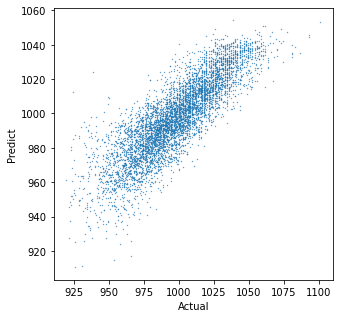

In [988]:
plt.figure(figsize=(5, 5))
plt.scatter( sc_turf_y.inverse_transform(y_test_turf_std) , sc_turf_y.inverse_transform(lasso_turf.predict(X_test_turf_std)), s=.1)
plt.xlabel("Actual")
plt.ylabel("Predict")
plt.show()

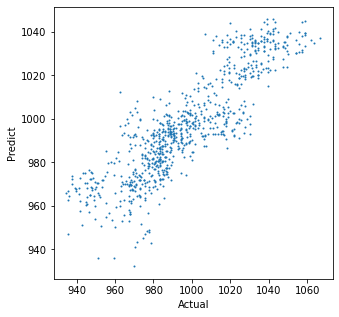

In [989]:
plt.figure(figsize=(5, 5))
plt.scatter( sc_turf_y.inverse_transform(y_valid_turf_std) , sc_turf_y.inverse_transform(lasso_turf.predict(X_valid_turf_std)), s=1)
plt.xlabel("Actual")
plt.ylabel("Predict")
plt.show()

In [914]:
dirt_result = df_DIRT_add_Valid[~df_DIRT_add_Valid["Valid"].isnull()][['Date', 'Place',  'R', 'Race_Name', "MPM", "Arrival_Number"]]
turf_result = df_TURF_add_Valid[~df_TURF_add_Valid["Valid"].isnull()][['Date', 'Place',  'R', 'Race_Name', "MPM", "Arrival_Number"]]
dirt_result["Arrival_Number"] = dirt_result["Arrival_Number"].astype("float")
turf_result["Arrival_Number"] = turf_result["Arrival_Number"].astype("float")

In [915]:
dirt_result["Predict_MPM"] = sc_dirt_y.inverse_transform(lasso_dirt.predict(X_valid_dirt_std))
turf_result["Predict_MPM"] = sc_turf_y.inverse_transform(lasso_turf.predict(X_valid_turf_std))

In [916]:
dirt_result = dirt_result.sort_values(['Date', 'Place',  'R', 'Race_Name', "Arrival_Number"])
turf_result = turf_result.sort_values(['Date', 'Place',  'R', 'Race_Name', "Arrival_Number"])

In [917]:
rank_dirt = []
i = 0
k = False
while i < len(dirt_result):
    j = i + 1
    while j < len(dirt_result):
        if j == len(dirt_result)-1:
            rank_dirt.append((-dirt_result.iloc[i:j+1, :]["Predict_MPM"]).rank().values)
            k = True
            break
        elif dirt_result["Date"].iat[i] == dirt_result["Date"].iat[j] and dirt_result["Place"].iat[i] == dirt_result["Place"].iat[j] and \
           dirt_result["R"].iat[i] == dirt_result["R"].iat[j] and dirt_result["Race_Name"].iat[i] == dirt_result["Race_Name"].iat[j]:
            pass

        else:
            rank_dirt.append((-dirt_result.iloc[i:j-1+1, :]["Predict_MPM"]).rank().values)
            i = j
        j += 1  
    if k == True:
        break

dirt_result["Predict_Arrival_Number"] =   np.hstack(np.array(rank_dirt))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [918]:
rank_turf = []
i = 0
k = False
while i < len(turf_result):
    j = i + 1
    while j < len(turf_result):
        if j == len(turf_result)-1:
            rank_turf.append((-turf_result.iloc[i:j+1, :]["Predict_MPM"]).rank().values)
            k = True
            break
        elif turf_result["Date"].iat[i] == turf_result["Date"].iat[j] and turf_result["Place"].iat[i] == turf_result["Place"].iat[j] and \
           turf_result["R"].iat[i] == turf_result["R"].iat[j] and turf_result["Race_Name"].iat[i] == turf_result["Race_Name"].iat[j]:
            pass

        else:
            rank_turf.append((-turf_result.iloc[i:j-1+1, :]["Predict_MPM"]).rank().values)
            i = j
        j += 1  
    if k == True:
        break

turf_result["Predict_Arrival_Number"] =   np.hstack(np.array(rank_turf))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [923]:
dirt_result["Arrival_Number_rev"] = dirt_result["Arrival_Number"].apply(lambda x : int(4) if x > 3 else int(x) )
dirt_result["Predict_Arrival_Number_rev"] = dirt_result["Predict_Arrival_Number"].apply(lambda x : int(4) if x > 3 else int(x) )
turf_result["Arrival_Number_rev"] = turf_result["Arrival_Number"].apply(lambda x : int(4) if x > 3 else int(x) )
turf_result["Predict_Arrival_Number_rev"] = turf_result["Predict_Arrival_Number"].apply(lambda x : int(4) if x > 3 else int(x) )

In [999]:
pd.pivot_table(dirt_result, index="Predict_Arrival_Number_rev", columns="Arrival_Number_rev", aggfunc="count", values="MPM")/len(dirt_result)*100

Arrival_Number_rev,1,2,3,4
Predict_Arrival_Number_rev,,,,
1,0.595238,0.833333,0.714286,5.119048
2,1.666667,0.833333,0.952381,3.809524
3,0.714286,0.833333,0.595238,5.119048
4,4.285714,4.880952,4.880952,64.166667


In [1046]:
np.sum(pd.pivot_table(dirt_result, index="Predict_Arrival_Number_rev", columns="Arrival_Number_rev", aggfunc="count", values="MPM")/len(dirt_result)*100, axis=1)

Predict_Arrival_Number_rev
1     7.261905
2     7.261905
3     7.261905
4    78.214286
dtype: float64

In [1000]:
pd.pivot_table(turf_result, index="Predict_Arrival_Number_rev", columns="Arrival_Number_rev", aggfunc="count", values="MPM")/len(turf_result)*100

Arrival_Number_rev,1,2,3,4
Predict_Arrival_Number_rev,,,,
1,1.477833,0.862069,0.369458,5.788177
2,0.738916,0.985222,1.231527,5.541872
3,0.369458,0.985222,1.477833,5.665025
4,5.911330,5.665025,5.541872,57.389163


In [1047]:
np.sum(pd.pivot_table(turf_result, index="Predict_Arrival_Number_rev", columns="Arrival_Number_rev", aggfunc="count", values="MPM")/len(turf_result)*100, axis=1)

Predict_Arrival_Number_rev
1     8.497537
2     8.497537
3     8.497537
4    74.507389
dtype: float64

## Search for best parameter(alpha)

### DIRT

In [868]:
#Define parameter which is wanted to be searched
hyperopt_parameters = {
    'alpha': hp.loguniform('alpha', -5, 0),
}

In [893]:
def objective(args):
    estimator = Lasso(**args)
    
    estimator.fit(X_train_dirt_std, y_train_dirt_std)
    
    predicts = estimator.predict(X_test_dirt_std)
    R2 = r2_score(y_test_dirt_std, predicts)
    return -1*R2

In [894]:
max_evals = 200
trials = Trials()

best = fmin(
    objective,
    hyperopt_parameters,
    algo=tpe.suggest,
    max_evals=max_evals,
    trials=trials,
    verbose=1
)

100%|█████████████████████████████████████████████| 200/200 [01:22<00:00,  2.44trial/s, best loss: -0.7280010880198041]


In [895]:
best

{'alpha': 0.006739019418903796}

### TURF

In [896]:
#Define parameter which is wanted to be searched
hyperopt_parameters = {
    'alpha': hp.loguniform('alpha', -5, 0),
}

In [899]:
def objective(args):
    estimator = Lasso(**args)
    
    estimator.fit(X_train_turf_std, y_train_turf_std)
    
    predicts = estimator.predict(X_test_turf_std)
    R2 = r2_score(y_test_turf_std, predicts)
    return -1*R2

In [900]:
max_evals = 200
trials = Trials()

best = fmin(
    objective,
    hyperopt_parameters,
    algo=tpe.suggest,
    max_evals=max_evals,
    trials=trials,
    verbose=1
)

100%|█████████████████████████████████████████████| 200/200 [00:14<00:00, 14.22trial/s, best loss: -0.7153033834548657]


In [901]:
best

{'alpha': 0.006739475090570964}

In [902]:
lasso_dirt = Lasso(alpha=0.006739)
lasso_dirt.fit(X_train_dirt_std, y_train_dirt_std)
print(lasso_dirt.score(X_train_dirt_std, y_train_dirt_std))
print(lasso_dirt.score(X_test_dirt_std, y_test_dirt_std))
print(lasso_dirt.score(X_valid_dirt_std, y_valid_dirt_std))

0.7308911105786966
0.7280010945870595
0.6227873820237491


In [983]:
lasso_turf = Lasso(alpha=0.006739)
lasso_turf.fit(X_train_turf_std, y_train_turf_std)
print(lasso_turf.score(X_train_turf_std, y_train_turf_std))
print(lasso_turf.score(X_test_turf_std, y_test_turf_std))
print(lasso_turf.score(X_valid_turf_std, y_valid_turf_std))

0.7216775784747593
0.715303869017325
0.754620683618299


## Odds

In [1051]:
np.percentile(df_DIRT["Odds"][df_DIRT["Arrival_Number"] == "1"].dropna(), 100)

450.1

In [1050]:
print(np.median(df_DIRT["Odds"][(df_DIRT["Arrival_Number"] == "1") & (df_DIRT["Odds"] <= np.percentile(df_DIRT["Odds"][df_DIRT["Arrival_Number"] == "1"].dropna(), 100))] ))

3.4


In [1052]:
print(np.mean(df_DIRT["Odds"][(df_DIRT["Arrival_Number"] == "1") & (df_DIRT["Odds"] <= np.percentile(df_DIRT["Odds"][df_DIRT["Arrival_Number"] == "1"].dropna(), 100))] ))

7.25463199442766


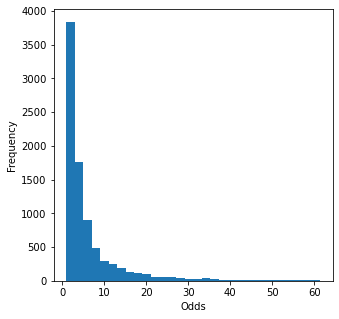

In [1040]:
plt.figure(figsize=(5, 5))
plt.hist( df_DIRT["Odds"][(df_DIRT["Arrival_Number"] == "1") & (df_DIRT["Odds"] <= np.percentile(df_DIRT["Odds"][df_DIRT["Arrival_Number"] == "1"].dropna(), 99))] , bins=30)
plt.xlabel("Odds")
plt.ylabel("Frequency")
plt.show()

In [1053]:
print(np.median(df_TURF["Odds"][(df_TURF["Arrival_Number"] == "1") & (df_TURF["Odds"] <= np.percentile(df_TURF["Odds"][df_TURF["Arrival_Number"] == "1"].dropna(), 100))] ))

4.7


In [1054]:
print(np.mean(df_TURF["Odds"][(df_TURF["Arrival_Number"] == "1") & (df_TURF["Odds"] <= np.percentile(df_TURF["Odds"][df_TURF["Arrival_Number"] == "1"].dropna(), 100))] ))

9.750421660008863


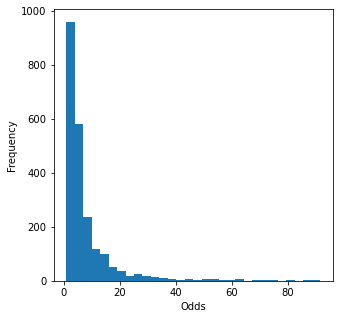

In [1041]:
plt.figure(figsize=(5, 5))
plt.hist( df_TURF["Odds"][(df_TURF["Arrival_Number"] == "1") & (df_TURF["Odds"] <= np.percentile(df_TURF["Odds"][df_TURF["Arrival_Number"] == "1"].dropna(), 99))] , bins=30)
plt.xlabel("Odds")
plt.ylabel("Frequency")
plt.show()